In [99]:
import argparse
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
from tqdm import tqdm
import struct
import pickle
from scipy.interpolate import RectBivariateSpline
import scipy as sp
import os
import glob
import numpy as np
np.seterr('raise')
from sklearn.linear_model import LinearRegression
import seaborn as sns
np.set_printoptions(precision=4)

%matplotlib notebook

def read_complex_binary2(filename):
    """ Read file of float32 into complex array.
    """

    with open(filename, 'rb') as f:
        bytes = f.read()
    data = np.frombuffer(bytes, dtype=np.float32).reshape(-1, 2)
    data = data[:, 0] + 1j*data[:, 1]
    return data

def get_rssis(filename):
    """ Get RSSI time series from file.
    """
    rssis = []
    data = read_complex_binary2(filename)
    num_frame = int(len(data)/65536 - 2)
    for i in range(num_frame):
        section = data[i*65536:(i+1)*65536]
        spectrum = 10*np.log10(np.fft.fftshift(np.abs(np.fft.fft(section))**2))
        rssis.append(np.max(spectrum[22929:22949]))
    rssis = np.array(rssis)
    return rssis

def get_model_mle(dirname, prefix, xs, ys):
    """ Get the likelihood model from directory of data files.
    """
    s_mean = np.full_like(np.meshgrid(xs,ys)[0], np.nan, dtype=np.float64)
    s_dev  = np.full_like(np.meshgrid(xs,ys)[0], np.nan, dtype=np.float64)

    for i, x in enumerate(tqdm(xs)):
        for j, y in enumerate(ys):
            filename = os.path.join(dirname, f"{prefix}{x:>02}{y:>02}.dat")
            filename_cached = os.path.splitext(filename)[0] + '.pkl'
            if os.path.exists(filename_cached):
                with open(filename_cached, 'rb') as f:
                    mean, std = pickle.load(f)
                s_mean[i,j] = mean
                s_dev[i,j] = std
            else:
                rssis = get_rssis(filename)
                if len(rssis):
                    mean, std = np.mean(rssis), np.std(rssis)
                    with open(filename_cached, 'wb') as f:
                        pickle.dump((mean,std), f)
                    s_mean[i,j] = mean
                    s_dev[i,j] = std
            
    f_mean = RectBivariateSpline(xs, ys, s_mean)
    f_dev = RectBivariateSpline(xs, ys, s_dev)
    
    return f_mean, f_dev

def get_sample_points(dirname, prefix, xs, ys):
    """ Get the likelihood model from directory of data files.
    """
    s_mean = np.full_like(np.meshgrid(xs,ys)[0], np.nan, dtype=np.float64)
    s_dev  = np.full_like(np.meshgrid(xs,ys)[0], np.nan, dtype=np.float64)

    for i, x in enumerate(tqdm(xs)):
        for j, y in enumerate(ys):
            filename = os.path.join(dirname, f"{prefix}{x:>02}{y:>02}.dat")
            filename_cached = os.path.splitext(filename)[0] + '.pkl'
            if os.path.exists(filename_cached):
                with open(filename_cached, 'rb') as f:
                    mean, std = pickle.load(f)
                s_mean[i,j] = mean
                s_dev[i,j] = std
            else:
                rssis = get_rssis(filename)
                if len(rssis):
                    mean, std = np.mean(rssis), np.std(rssis)
                    with open(filename_cached, 'wb') as f:
                        pickle.dump((mean,std), f)
                    s_mean[i,j] = mean
                    s_dev[i,j] = std
                    
    return s_mean, s_dev

# Plot Figures

## Localization CDF

<IPython.core.display.Javascript object>


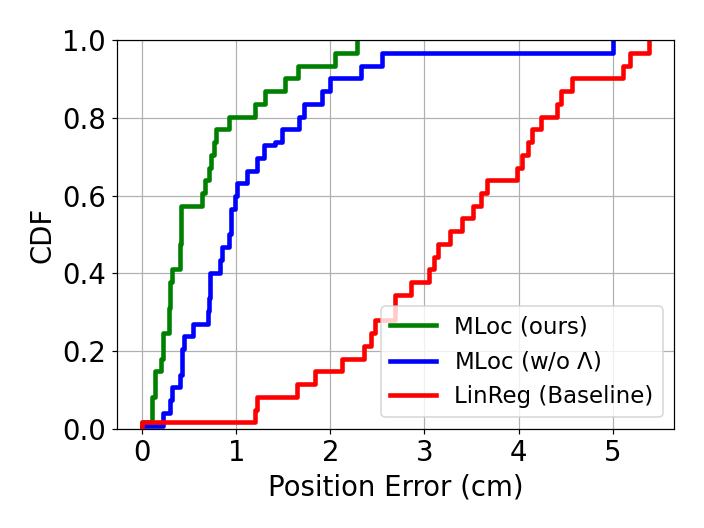

mle_median: 0.4123105625617663
mle_nl_median: 0.9326762794674746
lr_median: 3.27566787083184


In [115]:
with open('errors_mle.pkl', 'rb') as f:
    errors_mle = pickle.load(f)
    
with open('errors_mle_nl.pkl', 'rb') as f:
    errors_mle_nl = pickle.load(f)
    
with open('errors_mle_ns.pkl', 'rb') as f:
    errors_mle_ns = pickle.load(f)
    
with open('errors_lr.pkl', 'rb') as f:
    errors_lr = pickle.load(f)

fig, ax = plt.subplots()
#ax.set_title('Localization Accuracy')
ax.set(xlabel='Position Error (cm)', ylabel='CDF')
sns.ecdfplot(errors_mle, label='MLoc (ours)', color='g', linewidth=3.0, ax=ax)
sns.ecdfplot(errors_mle_nl, label='MLoc (w/o $\Lambda$)', color='b', linewidth=3.0, ax=ax)
#sns.ecdfplot(errors_mle_ns, label='MLoc (w/o $\sigma$)', ax=ax)
sns.ecdfplot(errors_lr, label='LinReg (Baseline)', color='r', linewidth=3.0, ax=ax)
ax.legend(prop={'size': 15})
ax.grid()
fig.tight_layout()
plt.show()
plt.savefig('localization_cdf.png')

print(f"mle_median: {np.median(errors_mle)}")
print(f"mle_nl_median: {np.median(errors_mle_nl)}")
print(f"lr_median: {np.median(errors_lr)}")

## RSSI Distribution

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 7903.84it/s]


<IPython.core.display.Javascript object>


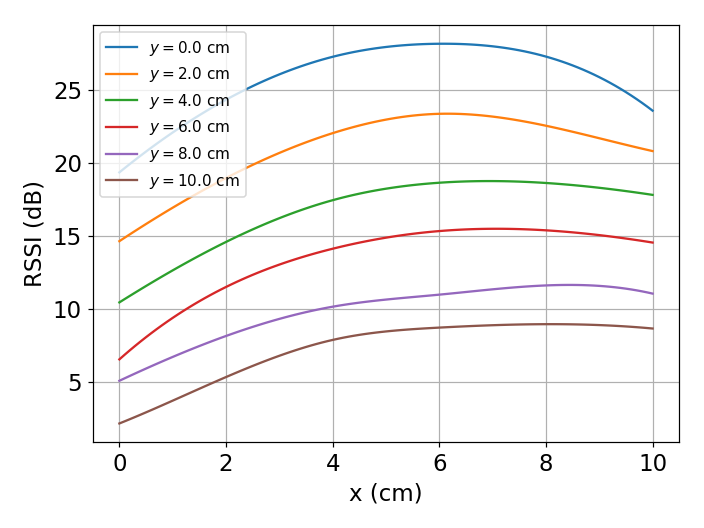

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 7842.26it/s]


<IPython.core.display.Javascript object>


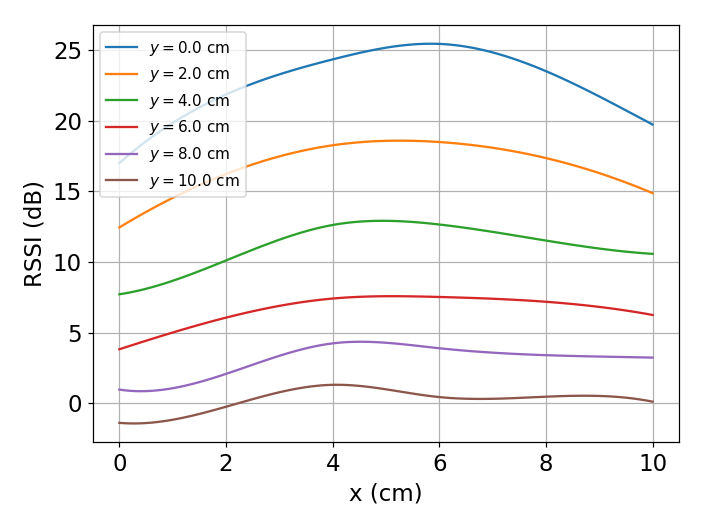

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 8689.86it/s]


<IPython.core.display.Javascript object>


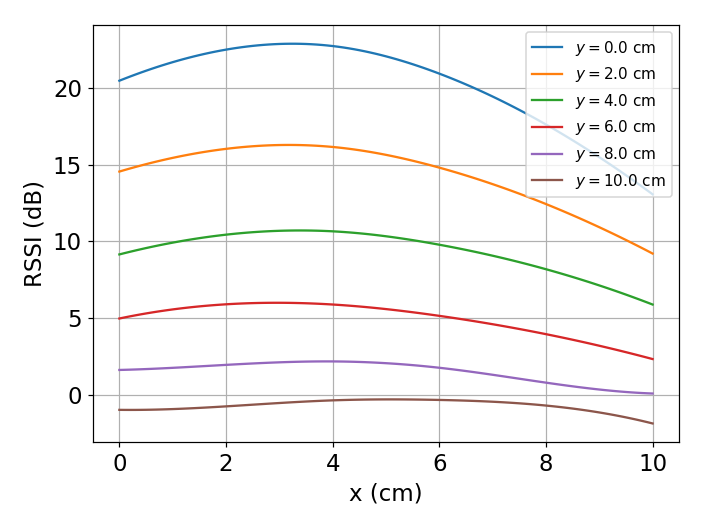

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 8371.86it/s]


<IPython.core.display.Javascript object>


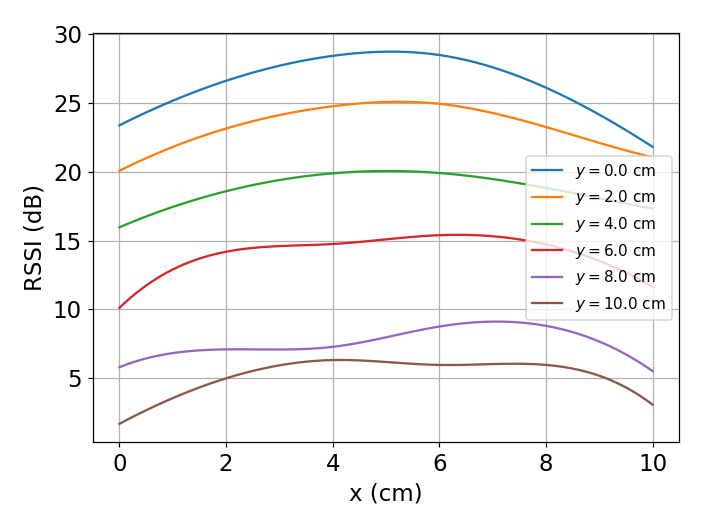

In [52]:
plt.rcParams.update({'font.size': 15})

datasets = ['data/sep-20-redo', 'data/sep-19-full', 'data/sep-18-first', 'data/Sep 17- redo water']

for dataset in datasets:
    f_mean, f_dev = get_model_mle(dataset, 0, np.arange(0,10+2,2), np.arange(0,10+2,2))
    
    fig, ax = plt.subplots()
    ys = np.arange(0,10+2.0,2.0)
    xs = np.arange(0,10+0.1,0.1)
    for y in ys:
        ax.plot(xs, [f_mean(x,y)[0,0] for x in xs], label=f"$y = {y}$ cm")
    ax.legend(prop={'size': 10})
    ax.grid()
    ax.set_ylabel('RSSI (dB)')
    ax.set_xlabel('x (cm)')
    fig.tight_layout()
    fig.show()
    plt.savefig('rssis_' + os.path.basename(dataset) + '.png')

## Regressing RSSI to Distance

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 8333.05it/s]


<IPython.core.display.Javascript object>


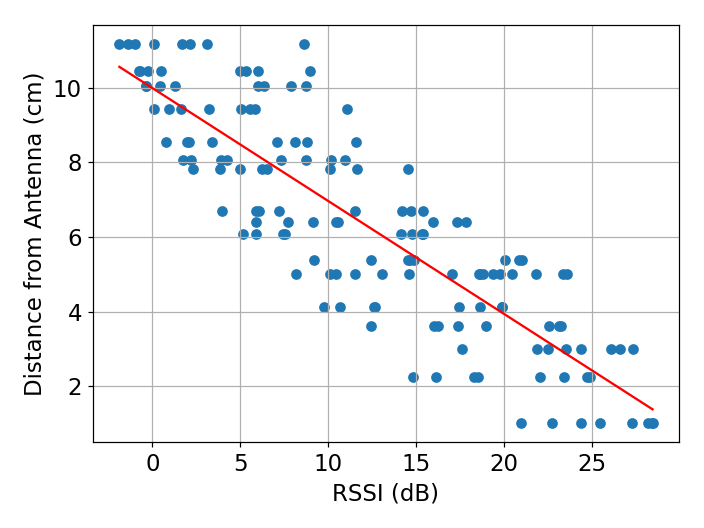

In [77]:
plt.rcParams.update({'font.size': 15})

datasets = ['data/sep-20-redo', 'data/sep-19-full', 'data/sep-18-first', 'data/Sep 17- redo water']

X = []
Y = []

for dataset in datasets:
    f_mean, f_dev = get_model_mle(dataset, 0, np.arange(0,10+2,2), np.arange(0,10+2,2))
    
    xs = np.arange(0,10+2,2)
    ys = np.arange(0,10+2,2)
    
    for x in xs:
        for y in ys:
            X.append(f_mean(x,y)[0,0])
            Y.append(np.linalg.norm([x-5.0,y]))
            
fig, ax = plt.subplots()
ax.scatter(X,Y)
ax.plot(np.unique(X), np.poly1d(np.polyfit(X, Y, 1))(np.unique(X)), color='r')
#ax.legend(prop={'size': 10})
ax.grid()
ax.set_xlabel('RSSI (dB)')
ax.set_ylabel('Distance from Antenna (cm)')
fig.tight_layout()
fig.show()
plt.savefig('rssi_vs_dist.png')

## GT Distance vs Prediction Error

<IPython.core.display.Javascript object>


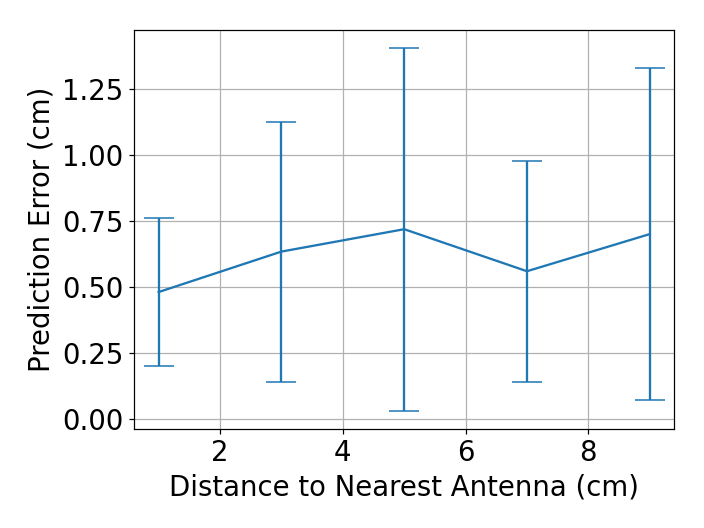

In [116]:
datasets = ['data/sep-20-redo', 'data/sep-19-full', 'data/sep-18-first']

dists = np.arange(1.0,11.0,2.0)
errs = [[] for _ in dists]

for dataset in datasets:
    with open(f"pred_mle_{os.path.basename(dataset)}.pkl", 'rb') as f:
        predictions = pickle.load(f)
    
    for pred in predictions:
        x_gt, y_gt, x_pred, y_pred, l = pred
        antenna_dist  = np.linalg.norm([x_gt-5.0, y_gt])
        idx = np.argmin(np.abs(antenna_dist - dists))
        errs[idx].append(np.linalg.norm([x_gt-x_pred, y_gt-y_pred]))
        
err_means = [np.mean(x) for x in errs]
err_stds  = [np.std(x) for x in errs]
    
fig, ax = plt.subplots()
ax.errorbar(dists, err_means, err_stds, capsize=10)
ax.grid()
ax.set_xlabel('Distance to Nearest Antenna (cm)')
ax.set_ylabel('Prediction Error (cm)')
fig.tight_layout()
fig.show()
plt.savefig('dist_vs_pred_err.png')

## Water vs Meat

<IPython.core.display.Javascript object>


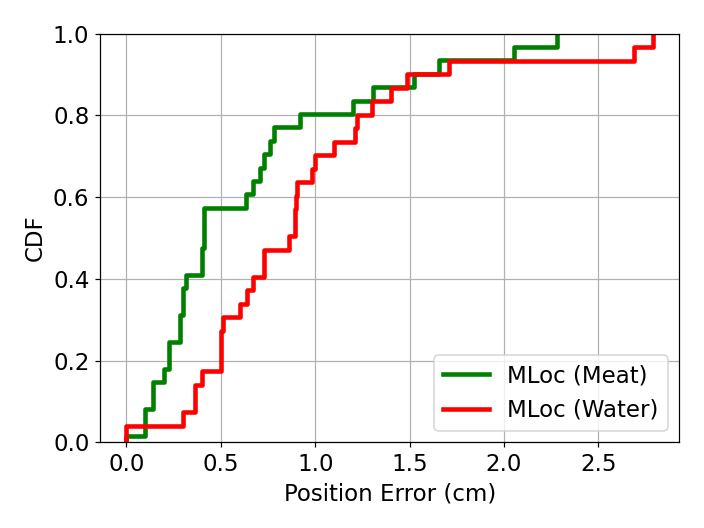

In [79]:
with open('errors_mle.pkl', 'rb') as f:
    errors_mle = pickle.load(f)
    
with open(f'error_mle_Sep 17- redo water.pkl', 'rb') as f:
    errors_mle_water = pickle.load(f)

fig, ax = plt.subplots()
#ax.set_title('Localization Accuracy')
ax.set(xlabel='Position Error (cm)', ylabel='CDF')
sns.ecdfplot(errors_mle, label='MLoc (Meat)', color='g', linewidth=3.0, ax=ax)
sns.ecdfplot(errors_mle_water, label='MLoc (Water)', color='r', linewidth=3.0, ax=ax)
ax.legend(prop={'size': 15})
ax.grid()
fig.tight_layout()
plt.show()
plt.savefig('meat_vs_water_cdf.png')

## Lambda Difference

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 8062.87it/s]


-0.6551728818855536


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 9709.04it/s]


-1.8570117276640639


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10375.52it/s]

2.1939571381722733


<IPython.core.display.Javascript object>


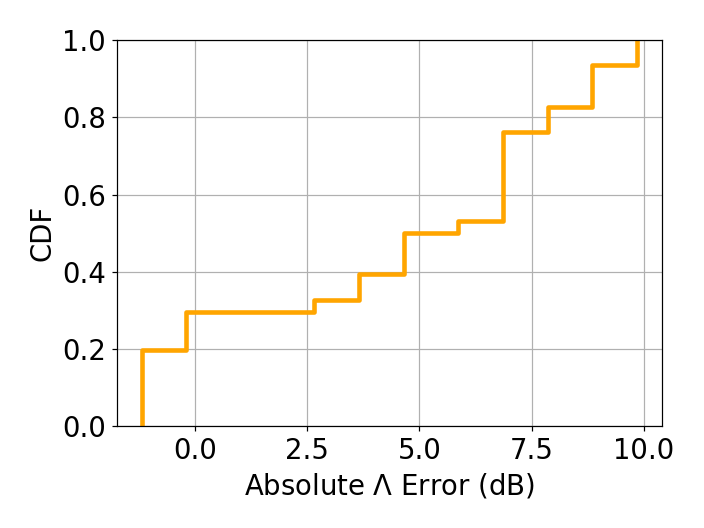

In [113]:
datasets = ['data/sep-20-redo', 'data/sep-19-full', 'data/sep-18-first']

errs = []

for dataset in datasets:
    
    if dataset != 'data/sep-20-redo':
        f_air, _  = get_model_mle(dataset, 0, np.arange(2,8+2,2), np.arange(2,8+2,2))
        f_meat, _ = get_model_mle(dataset, 1, np.arange(2,8+2,2), np.arange(2,8+2,2))
    else:
        f_air, _  = get_model_mle(dataset, 0, np.arange(2,8+2,2), np.arange(2,8+2,2))
        f_meat, _ = get_model_mle(dataset, 1, np.arange(1,8+2,2), np.arange(1,8+2,2))
        
    X, Y = np.meshgrid(np.arange(0,10+2,2), np.arange(0,10+2,2))
    Z_air  = f_air(X, Y, grid=False)
    Z_meat = f_meat(X, Y, grid=False)
    
    lambda_gt = np.mean((Z_air - Z_meat).flatten())
    print(lambda_gt)
    
    with open(f"pred_mle_{os.path.basename(dataset)}.pkl", 'rb') as f:
        predictions = pickle.load(f)
    
    for pred in predictions:
        x_gt, y_gt, x_pred, y_pred, lambda_pred = pred
        errs.append(lambda_pred - lambda_gt)
        
fig, ax = plt.subplots()
ax.set(xlabel='Absolute $\Lambda$ Error (dB)', ylabel='CDF')
sns.ecdfplot(errs, color='orange', linewidth=3.0, ax=ax)
ax.grid()
fig.tight_layout()
plt.show()
plt.savefig('lambda_cdf.png')

# On Grid vs Off Grid

122 122


<IPython.core.display.Javascript object>


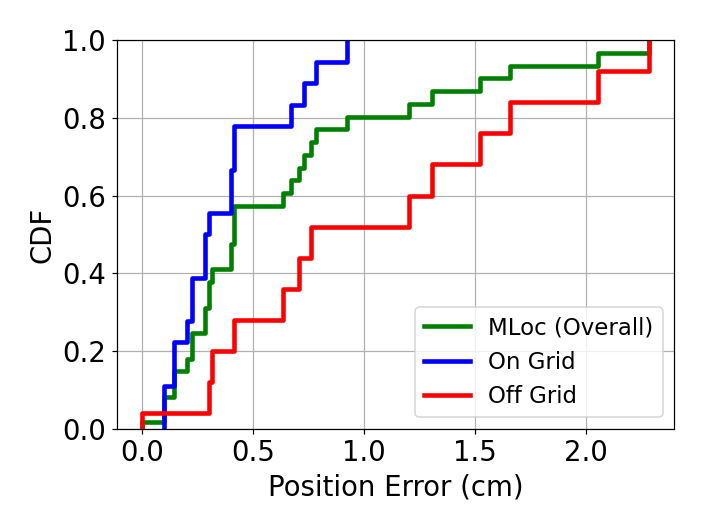

median_overall:  0.4123105625617663
median_on_grid:  0.29142135623730947
median_off_grid: 0.7615773105863908


In [109]:
with open('errors_mle.pkl', 'rb') as f:
    errors_mle = pickle.load(f)
    
datasets = ['data/sep-20-redo', 'data/sep-19-full', 'data/sep-18-first']

preds_mle = []
for dataset in datasets:
    with open(f"pred_mle_{os.path.basename(dataset)}.pkl", 'rb') as f:
        predictions = pickle.load(f)
    preds_mle += predictions
    
print(len(errors_mle), len(preds_mle))
    
errs_on  = []
errs_off = []

for pred in preds_mle:
    x_gt, y_gt, x_pred, y_pred, lambda_pred = pred
    if x_gt % 2 == 0:
        # On grid
        errs_on.append(np.linalg.norm([x_gt-x_pred,y_gt-y_pred]))
    else:
        # Off grid
        errs_off.append(np.linalg.norm([x_gt-x_pred,y_gt-y_pred]))

fig, ax = plt.subplots()
#ax.set_title('Localization Accuracy')
ax.set(xlabel='Position Error (cm)', ylabel='CDF')
sns.ecdfplot(errors_mle, label='MLoc (Overall)', color='g', linewidth=3.0, ax=ax)
sns.ecdfplot(errs_on,  label='On Grid',  color='b', linewidth=3.0, ax=ax)
sns.ecdfplot(errs_off, label='Off Grid', color='r', linewidth=3.0, ax=ax)
ax.legend(prop={'size': 15})
ax.grid()
fig.tight_layout()
plt.show()
plt.savefig('on_vs_off_grid_cdf.png')
print(f"median_overall:  {np.median(errors_mle)}")
print(f"median_on_grid:  {np.median(errs_on)}")
print(f"median_off_grid: {np.median(errs_off)}")